-----------

# TRABAJO PRACTICO FINAL

### DIGITAL HOUSE: Data Science
### Junio 2022

<br>

## GRUPO 1
- Integrantes:
    - Gonzalo Barbot - PM: Project Manager
    - Agustin Stigliano - CDM: Code Development Manager
    - Fernando Dupont - PDM: Presentation Development Manager
    
<br>

## TEMA: Pronósticos sobre Series Temporales
<br>

-----

# NOTEBOOK MACHINE LEARNING:


In [1]:
import SmartPandas, SmartSeries
import APP_REG_LOG_EST as reg
import APP_ARIMA as arima
import APP_XGBOOST as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import pickle

import logging
import datetime as dt
formatter = '%(levelname)s:\n %(message)s | %(asctime)s\n'#| line %(lineno)d\n'
logging.basicConfig(filename='logfile_Machine_learning.log', level=logging.INFO, force=True, filemode='w', **{'format':formatter})
logger = logging.getLogger()

Libreria SmartPandas:
	Clases:
		- PandasTransform, PandasFeatureUnion
Libreria SmartSeries:
	Clases:
		- VectorBuilder() 
	Funciones:
		- load_dataset
>> APP REG_LOG_EST: APLICACION PARA ENTRENAR Y EXPORTAR UN MODELO DE REGRESION LINEAL CON TRANSFORMACION LOGARITMICA APLICANDO ESTACIONALIDAD
>> APP ARIMA: Recibe una serie, y aplica logaritmo, 3 procesos de diferenciacion y un proceso de optimización, luego grafica para visualizar resultados y seleccionar parámetros ARIMA
>> APP XGBOST: APLICACION XGBOOST PARA TIME SERIES FORECASTING

xgboost version actual: 1.5.0
Version de diseño en 14/6/2022
	xgboost version: 1.6.0


In [2]:
from SmartPandas import x_en
def x():
    return x_en('log_ML')

In [3]:
logger.info('{}) STARTING PROGRAM'.format(x()))

In [4]:
file_name = 'df_targets.csv'

df = SmartSeries.load_dataset(file_name, freq='D', dropnan=False, fillnan=True)
logger.info('{}) LOADING FUNCTION: load_dataset(): se carga el dataset llamado "{}"'.format(x(), file_name))

display (df)
print (df.index)
display (SmartPandas.data_info(df))


Serie de tiempo: date

Cantidad de NaNs en: 
Grocery             0
Pharmaceutical      0
Natural Products    0
Bakery              1
Meat                1
NaNs imputados: método "backfill"


,Grocery,Pharmaceutical,Natural Products,Bakery,Meat
date,,,,,
2012-04-10,125.835760,349.128351,101.781519,161.637857,353.698462
2012-04-11,146.691058,179.865346,101.030875,123.934848,222.319762
2012-04-12,164.758837,195.612941,114.137453,158.606944,521.658136
2012-04-13,152.669070,169.872827,106.682081,182.599318,521.257895
2012-04-14,126.721540,198.341983,126.068018,125.618571,327.602143
...,...,...,...,...,...
2013-06-26,112.263581,292.195754,103.016559,149.655882,223.138889
2013-06-27,120.195221,222.045030,100.582025,151.791714,392.826829
2013-06-28,130.841667,189.297044,87.684000,116.581364,228.294590


DatetimeIndex(['2012-04-10', '2012-04-11', '2012-04-12', '2012-04-13',
               '2012-04-14', '2012-04-15', '2012-04-16', '2012-04-17',
               '2012-04-18', '2012-04-19',
               ...
               '2013-06-21', '2013-06-22', '2013-06-23', '2013-06-24',
               '2013-06-25', '2013-06-26', '2013-06-27', '2013-06-28',
               '2013-06-29', '2013-06-30'],
              dtype='datetime64[ns]', name='date', length=447, freq='D')


info de data,columna,Nan,pct_nan,dtype,count,pct_reg,count_unique
0,Bakery,0,0.0,float64,447,100.0,446
1,Meat,0,0.0,float64,447,100.0,446
2,Grocery,0,0.0,float64,447,100.0,447
3,Pharmaceutical,0,0.0,float64,447,100.0,447
4,Natural Products,0,0.0,float64,447,100.0,447


In [5]:
df.isna().sum()

Grocery             0
Pharmaceutical      0
Natural Products    0
Bakery              0
Meat                0
dtype: int64

In [6]:
labels_category = df.columns.values

vector = SmartSeries.VectorBuilder(df)
vectores = {}
for elemento in labels_category:
    vector.create(elemento)
    vector.treatment()
    vector.dummy('W')
    vectores[elemento] = vector.vector


Serie de tiempo: date



In [7]:
vector.targets

['Grocery', 'Pharmaceutical', 'Natural Products', 'Bakery', 'Meat']

**MODELO DE REGRESION LINEAL CON TRANSFORMACIÓN LOGARÍTMICA Y ESTACIONALIDAD**

**division de los sets**

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [8]:
from sklearn.pipeline import Pipeline, make_pipeline
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [9]:
train_test_cv = TimeSeriesSplit()
train_test_cv2 = TimeSeriesSplit(n_splits=2, test_size=None, gap=0, max_train_size=None)
train_test_cvv = TimeSeriesSplit(n_splits=3, test_size=None)# hacer 3 predicciones al año

In [10]:
muestra = vectores['Meat']
modelos = reg.available_models()
nombre_modelos = reg.def_models()

for i in range(len(modelos)):
    modelos[i] = modelos[i](muestra, vector)

df_train, df_test = train_test_split(muestra, shuffle=False)

scores = []
for i in range(len(modelos)):
    modelos[i] = modelos[i].fit()
    y_pred = modelos[i].predict(df_test)
    if i <= 3: y_pred = np.exp(y_pred) # los primeros 4 modelos predicen sobre el logartimo del target
    scores.append(np.sqrt(mean_squared_error(df_test[vector.target], y_pred)))

resultados = {}
results = pd.DataFrame([nombre_modelos, scores]).T
results.columns = ['Modelo', 'RMSE']


optimized_model = modelos[pd.Series(scores).idxmin()]

In [11]:
results

,Modelo,RMSE
0,log_trend_est,74.4987
1,log_trend_est_sq,74.4843
2,log_trend,79.6669
3,log_trend_sq,79.7878
4,lin_trend,79.4645
5,lin_trend_sq,79.2825


**ESTUDIO DE SERIES ESTACIONARIAS, PRUEBA DE HIPOTESIS SOBRE LOS RESIDUOS Y SOBRE PROCESO DE DIFERENCIACION ESTANDAR**

c:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


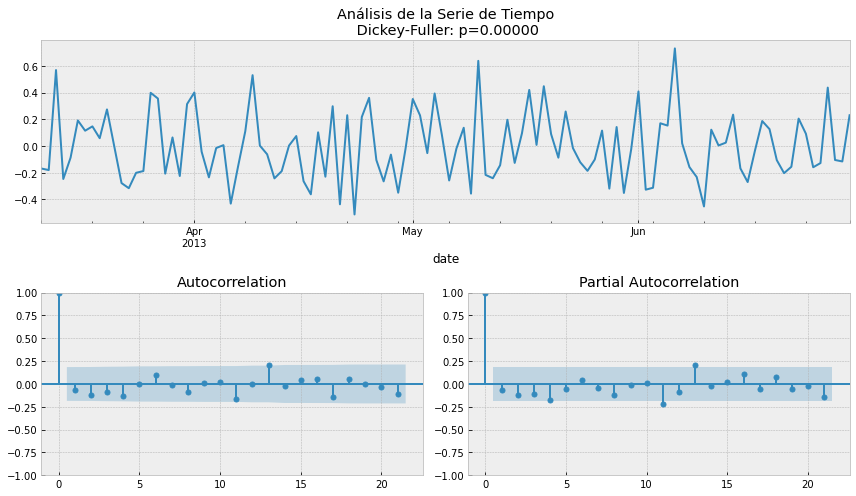

In [29]:
y_test = df_test['log_Meat'] 
y_real = df_test['Meat']

y_pred = optimized_model.predict(df_test)

residuo = y_test - y_pred

arima.params_set_plot(residuo)

	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 12



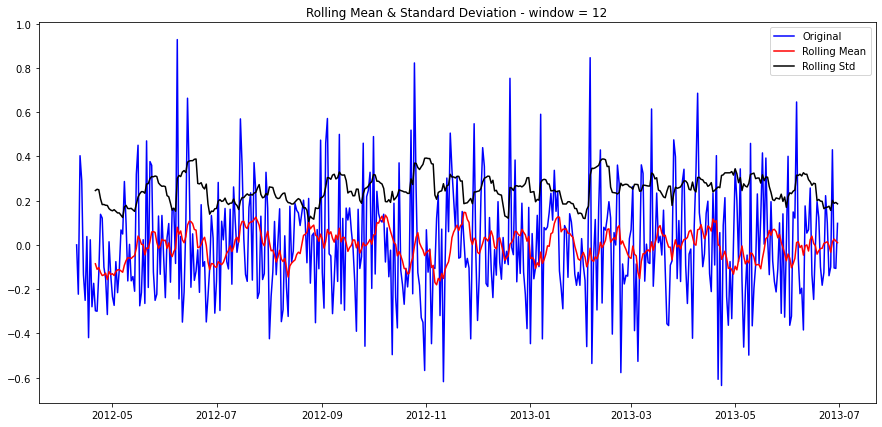

	DICK-FULLER TEST
ADF Statistic: -21.317425752300498
p-value: 0.0
Critical Values:
	1%: -3.4450973903602367
	5%: -2.868042229965336
	10%: -2.570233448893


In [28]:
diferenciacion = arima.test_stationarity(muestra)#.iloc[:,0].resample('2d').sum())

In [14]:
muestra

,Meat,log_Meat,timeIndex,timeIndex_sq,sem_00,sem_01,sem_02,sem_03,sem_04,sem_05,...,sem_44,sem_45,sem_46,sem_47,sem_48,sem_49,sem_50,sem_51,sem_52,sem_53
date,,,,,,,,,,,,,,,,,,,,,
2012-04-10,353.698462,5.868445,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-11,222.319762,5.404117,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-12,521.658136,6.257012,2,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-13,521.257895,6.256245,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-14,327.602143,5.791800,4,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-26,223.138889,5.407794,442,195364,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-06-27,392.826829,5.973369,443,196249,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-06-28,228.294590,5.430637,444,197136,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


c:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


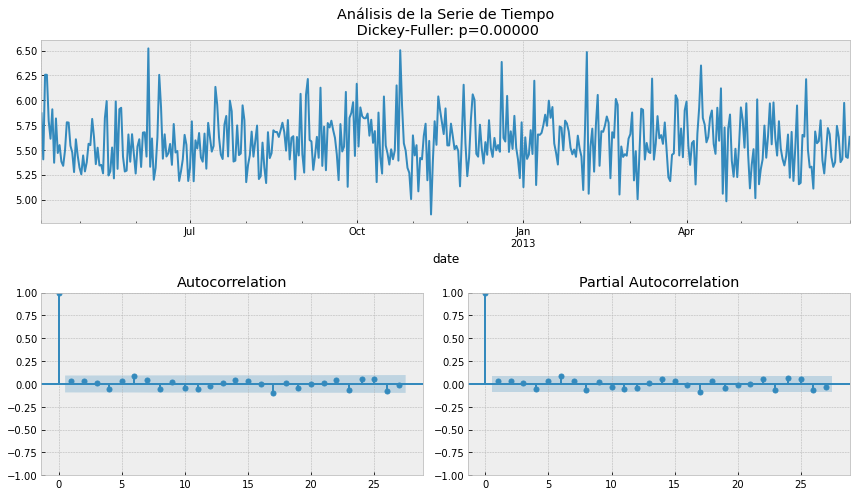

In [15]:
arima.params_set_plot(muestra['log_Meat'])

**MODELO ARIMA**

In [16]:
error, df_test_xgboost, df_pred_xgboost = xgb.walk_forward_validation(muestra['Meat'].to_frame(), n_test=10)

100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

>expected=206.2, predicted=364.4
>expected=216.2, predicted=291.2
>expected=311.6, predicted=260.3
>expected=278.0, predicted=401.6
>expected=216.3, predicted=471.5
>expected=223.1, predicted=311.5
>expected=392.8, predicted=315.9
>expected=228.3, predicted=233.7
>expected=225.8, predicted=192.8
>expected=279.0, predicted=457.6


**MODELO XGBOOST**

In [17]:
#RMSE
np.sqrt(error)

126.66876568436277

**MODELO DE ENSAMBLE**

**CONCLUSIONES**